<a href="https://colab.research.google.com/github/samanthastaheli/CSE450TeamProjects/blob/main/Mod4Elijah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q -U keras-tuner

In [2]:
!rm -r untitled_project 

rm: cannot remove 'untitled_project': No such file or directory


In [3]:
import pandas as pd
import tensorflow as tf
import datetime
import altair as alt
from tensorflow import keras
import keras_tuner as kt
from keras import layers
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras_tuner.tuners import RandomSearch
from keras_tuner.tuners import Hyperband
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import r2_score


bikes = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv')

In [ ]:
bikes.info()

## Data Preprocess (Initial)

In [5]:
bikes["month"] = bikes.apply(lambda x: int(x.dteday.split("/")[0]), axis=1)

In [6]:
bikes["day"] = bikes.apply(lambda x: int(x.dteday.split("/")[1]), axis=1)

In [7]:
bikes["year"] = bikes.apply(lambda x: int(x.dteday.split("/")[2]) + 2000, axis=1)

In [8]:
bikes["total_renters"] = bikes["casual"] + bikes["registered"]

In [9]:
bikes["week_day"] = bikes.apply(lambda x: datetime.date(x.year, x.month, x.day).weekday(), axis=1)

In [ ]:
alt.data_transformers.disable_max_rows()
alt.Chart(bikes).mark_line().encode(alt.X("temp_c"), alt.Y("mean(total_renters)"))

In [ ]:
alt.Chart(bikes).mark_bar().encode(alt.X("week_day:O"),alt.Y("mean(total_renters)"))

In [ ]:
alt.Chart(bikes).mark_bar().encode(alt.X("week_day:O"),alt.Y("sum(total_renters)"))

In [13]:
tbell_curve = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,0,1,2,3,4]

In [ ]:
alt.Chart(bikes).mark_bar().encode(alt.X("hr:O", sort=tbell_curve),alt.Y("mean(total_renters)"))

In [17]:
hr_bin = [-1,6,11,16,20,24]
hr_labels = ["morning_non", "morning_peak","afternoon","evening_peak","evening_non"]
bikes["time_bin"] = pd.cut(bikes["hr"], bins = hr_bin, labels = hr_labels)

In [18]:
bikes = pd.get_dummies(bikes, columns=["week_day"])

In [19]:
bikes = pd.get_dummies(bikes, columns=["time_bin"])

## Train Test Splits and HyperParameter Tuning


In [21]:
def build_model(hp):
    model = Sequential()
    model.add(layers.Flatten(input_shape=(24,)))
    model.add(Dense(units=hp.Int("units", min_value=32, max_value=512, step=32), activation="relu"))
    model.add(keras.layers.Dropout(0.2))
    model.add(Dense(units=hp.Int("units", min_value=32, max_value=512, step=32), activation="relu"))
    #Output layer
    model.add(layers.Dense(1, activation="linear"))
    #Test Learning Rates
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 2e-2, 5e-3, 1.5e-2])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss="mse", metrics=["mse"])
    return model

In [22]:
# tuner = RandomSearch(
#     hypermodel=build_model,
#     objective="val_loss",
#     max_trials=5,
#     executions_per_trial=2)

In [23]:
tuner = Hyperband(
    hypermodel=build_model,
    objective="val_loss",
    max_epochs=50,
    factor=3
) 

In [24]:
X = bikes.drop(columns=["dteday", "registered","casual", "total_renters"])
y = bikes.total_renters

In [25]:
X2, X_test, y2, y_test = train_test_split(X, y, test_size=0.1)

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X2, y2, test_size=0.15)

In [ ]:
X_test.shape
X_val.shape

In [ ]:
X_train.info()

In [29]:
# Scale the data
minmax_scaler = preprocessing.MinMaxScaler()
X_train = minmax_scaler.fit_transform(X_train) # fit the scale to the training data
X_val = minmax_scaler.transform(X_val) # use the same scale on the validation data
X_test = minmax_scaler.transform(X_test) # use the same scale on the testing data

In [30]:
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

In [ ]:
tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[es])

In [32]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 512 and the optimal learning rate for the optimizer
is 0.005.



## Initial Neural Network

In [34]:
model = build_model(best_hps)

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 24)                0         
                                                                 
 dense_3 (Dense)             (None, 512)               12800     
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 275,969
Trainable params: 275,969
Non-trainable params: 0
_________________________________________________________________


In [36]:
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=25)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, callbacks=[es])

In [38]:
# Evaluate the model on the training data
_, train_mse = model.evaluate(X_train, y_train, verbose = 1)

# Evaluate the model on the validating data
_, val_mse = model.evaluate(X_val, y_val, verbose = 1)

# Evaluate the model on the testing data
_, test_mse = model.evaluate(X_test, y_test, verbose = 1)

52/52 [==============================] - 0s 4ms/step - loss: 1580.5040 - mse: 1580.5040


In [39]:
predictions = model.predict(X_val)
r2 = r2_score(y_val, predictions)
print("Validation Set R2:",r2)

Validation Set R2: 0.9489988204160308


In [40]:
predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions)
print("Test Set R2:",r2)

Test Set R2: 0.9507920355362378


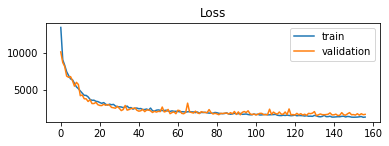

In [41]:
from matplotlib import pyplot
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()

## Post Processing/Results Analysis

In [133]:
#POST PROCESSING
df = pd.DataFrame(predictions, columns=["predicted"])
df2 = y_test.to_frame().reset_index()
df2 = df2.drop(columns=["index"])
df = pd.concat([df, df2], axis=1)
df["predicted"] = df.apply(lambda x: round(x.predicted) if x.predicted > 0 else 1, axis=1)

1

In [134]:
df["diff"] = df.apply(lambda row : row["total_renters"] - row["predicted"], axis=1)
df["abs_diff"] = df.apply(lambda row : abs(row["total_renters"] - row["predicted"]), axis=1)

In [135]:
alt.Chart(df).mark_circle().encode(alt.X("total_renters"), alt.Y("predicted"), color="abs_diff")

alt.Chart(...)